# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import numpy as np
import os
import random

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

In [3]:
tmp_df = pd.read_csv(data_dir+'test_data.csv')
tmp_df = tmp_df[tmp_df['answerCode']!=-1]

In [4]:
df = pd.concat([df,tmp_df])

In [5]:
df.sort_values(by=['userID','Timestamp'], inplace=True)

## 2. Feature Engineering

In [6]:
def minsum(s):
    a = np.sort(s)
    if a[0] == 0:
        a[0] = 1
    ans = 0
    length = 0
    for i in a:
        if i>a[0]*5:
            break
        ans += i
        length += 1
    return ans / length

def boundsum(s):
    a = np.sort(s)
    n = 1000
    ans = 0
    length = 0
    for i in a:
        if i>n:
            break
        ans += i
        length += 1
    if length == 0:
        return 10
    return ans / length

In [7]:
df['datetime'] = pd.to_datetime(df['Timestamp'],infer_datetime_format=True)
df['seconds'] = df['datetime'].apply(lambda x: x.timestamp())
diff = df.loc[:,['userID','seconds']].groupby('userID').diff(periods=-1)
df['seconds'] = diff['seconds'].apply(abs)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,datetime,seconds
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,2020-03-24 00:17:11,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2020-03-24 00:17:14,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2020-03-24 00:17:22,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,2020-03-24 00:17:29,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,2020-03-24 00:17:36,11.0


In [8]:
time_groupyby = df.groupby(['answerCode','assessmentItemID']).agg({'seconds': minsum})
time_groupyby = time_groupyby.loc[1].sort_values(by='seconds')
time_groupyby.loc['A050001007'] = 1000
time_groupyby.columns = ['meanSeconds']

In [9]:
time_groupyby = df.groupby(['answerCode','KnowledgeTag']).agg({'seconds': boundsum})
time_groupyby = time_groupyby.loc[1].sort_values(by='seconds')
time_groupyby.columns = ['meanSeconds']

In [10]:
user_time_group = df.groupby(['userID','KnowledgeTag']).agg({'seconds': boundsum})
user_time_group.columns = ['userSeconds']

In [11]:
len(time_groupyby)

912

In [12]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    # df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']
    # BSS data preprocess
    correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean','sum'])
    correct_a.columns = ["item_mean", 'item_sum']

    # KSY data preprocess
    df['month'] = df['Timestamp'].str[5:7].astype(int)
    df['category_2'] = df['assessmentItemID'].str[2].astype(int)
    df['test_paper'] = df['assessmentItemID'].str[4:7].astype(int)
    df['problem_id'] = df['assessmentItemID'].str[-3:].astype(int)



    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    # BSS data preprocess
    df = pd.merge(df, time_groupyby, on=['KnowledgeTag'], how='left')
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how='left')
    df = pd.merge(df, user_time_group, on=['userID','KnowledgeTag'], how='left')
    
    return df

In [13]:
df = feature_engineering(df)
df.tail()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,datetime,seconds,user_correct_answer,user_total_answer,...,test_paper,problem_id,test_mean,test_sum,tag_mean,tag_sum,meanSeconds,item_mean,item_sum,userSeconds
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2020-06-05 06:50:21,6632178.0,1.0,4,...,71,5,0.666000,999,0.694889,3127,62.354994,0.446667,134,55.0
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2020-08-21 01:06:39,11.0,1.0,5,...,165,1,0.653878,784,0.700029,2413,53.623096,0.643333,193,NaN
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2020-08-21 01:06:50,46.0,2.0,6,...,165,2,0.653878,784,0.700029,2413,53.623096,0.640000,192,NaN
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2020-08-21 01:07:36,73.0,3.0,7,...,165,3,0.653878,784,0.700029,2413,53.623096,0.786667,236,NaN
2525955,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,2020-08-21 01:08:49,NaN,4.0,8,...,165,4,0.653878,784,0.700029,2413,53.623096,0.545151,163,NaN


## 3. Train/Test 데이터 셋 분리

In [14]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]
    
    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [15]:
# 유저별 분리
train, test = custom_train_test_split(df)

In [16]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [17]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','month','category_2','test_paper','problem_id','item_mean','item_sum','userSeconds','meanSeconds'] #'meanSeconds']#,'userSeconds']
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'tag_mean','month','category_2','test_paper','problem_id','meanSeconds','item_mean']


In [18]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [19]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [20]:
param = {'objective': 'binary',
    'max_depth':8,
    'num_iterations':10000,
    'num_leaves':14,
    'learning_rate':0.01,}
model = lgb.train(
    param, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=1000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 1154972, number of negative: 613046
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 1768018, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653258 -> initscore=0.633391
[LightGBM] [Info] Start training from score 0.633391
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530199	valid_1's binary_logloss: 0.628228
[200]	training's binary_logloss: 0.503803	valid_1's binary_logloss: 0.601993
[300]	training's binary_logloss: 0.49506	valid_1's binary_logloss: 0.594026
[400]	training's binary_logloss: 0.491205	valid_1's binary_logloss: 0.590733
[500]	training's binary_logloss: 0.489223	valid_1's binary_logloss:

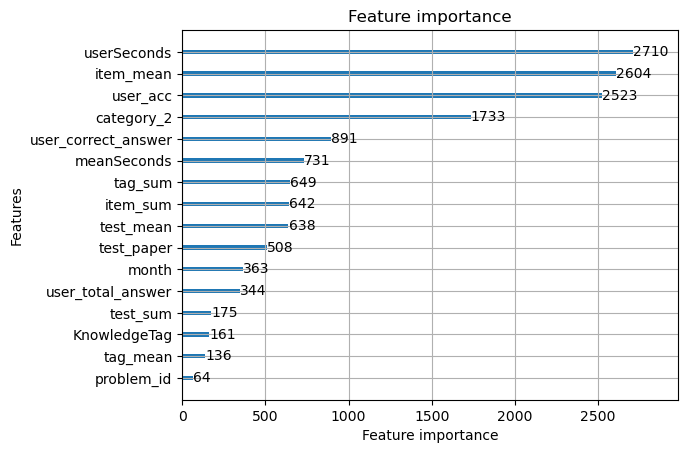

In [21]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [22]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df.sort_values(['userID','Timestamp'], inplace=True)
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [23]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [24]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/LGBM_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

